In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.simplefilter(action='ignore')

Populating the interactive namespace from numpy and matplotlib


### Load in the train data and test data

In [2]:
app_train = pd.read_csv("../data/application_train.csv")

In [3]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_train.shape

(307511, 122)

### EDA

In [5]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
#Check for missing values

(app_train.isna().sum() / app_train.shape[0]).sort_values(ascending=False)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
                              ...   
NAME_HOUSING_TYPE           0.000000
NAME_FAMILY_STATUS          0.000000
NAME_EDUCATION_TYPE         0.000000
NAME_INCOME_TYPE            0.000000
SK_ID_CURR                  0.000000
Length: 122, dtype: float64

In [7]:
#Put them in the dataframe to see the percentage of missing values

null_total = app_train.isnull().sum().sort_values(ascending=False)
null_percent = (app_train.isnull().sum()/app_train.isnull().count()*100).sort_values(ascending = False)
null_df = pd.concat([null_total, null_percent], axis=1, keys=['Total', 'Percent'])

null_df

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [8]:
#Threshold of null: 20%
print('There are {} features that have more than 20% of rows contains null values'.format(len(null_df[null_percent > 20].index)))
print('They are: ', null_df[null_percent > 20].index)

There are 50 features that have more than 20% of rows contains null values
They are:  Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE',
       'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE',
       'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE',
   

We need to find the way to deal with missing values, except for our buddy XGBoost

In [9]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [10]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [11]:
app_train.TARGET.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

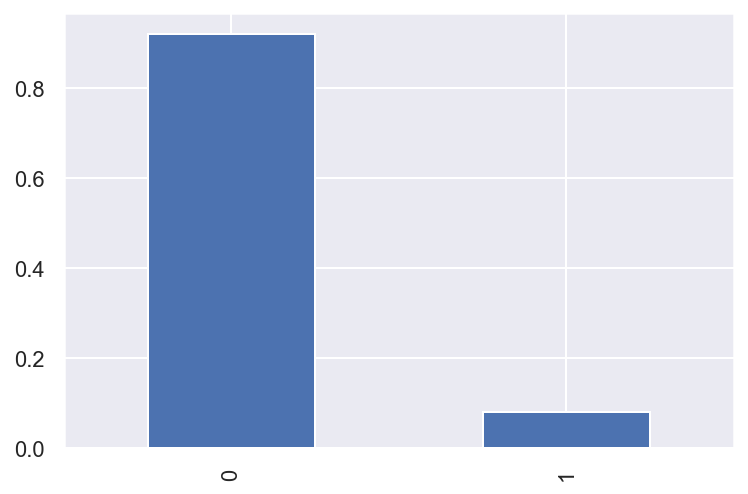

In [12]:
app_train.TARGET.value_counts(normalize=True).plot(kind='bar');

This is an **imbalanced class problem**

In [13]:
# Columns types
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [14]:
app_train.select_dtypes('O').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
#Perform one_hot encoding for categorical variables
app_train = pd.get_dummies(app_train)

app_train.shape

(307511, 246)

In [16]:
#columns with type of number (both in and float)
app_train.select_dtypes('number').columns.values

array(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPAR

In [17]:
app_train.DAYS_EMPLOYED.describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

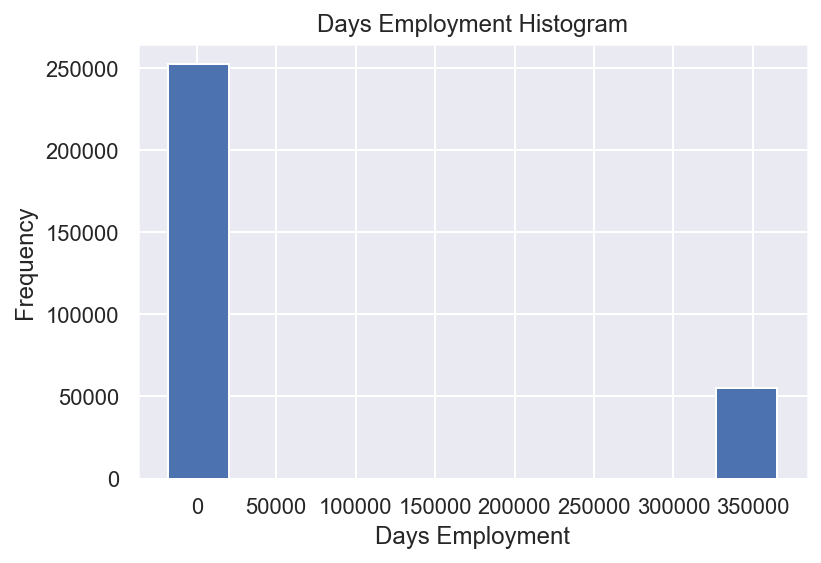

In [18]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

There are anomolies on the days employment columns since 365243 days is around 1000 years. Let's investigate it a bit further.

In [19]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Since there are *55374* anomalous days of employment and they all have the same value of *365243*, there must be some kind of impact on the dataset. Besides, the percentage of default of anomalies is lower than non-anomalies.

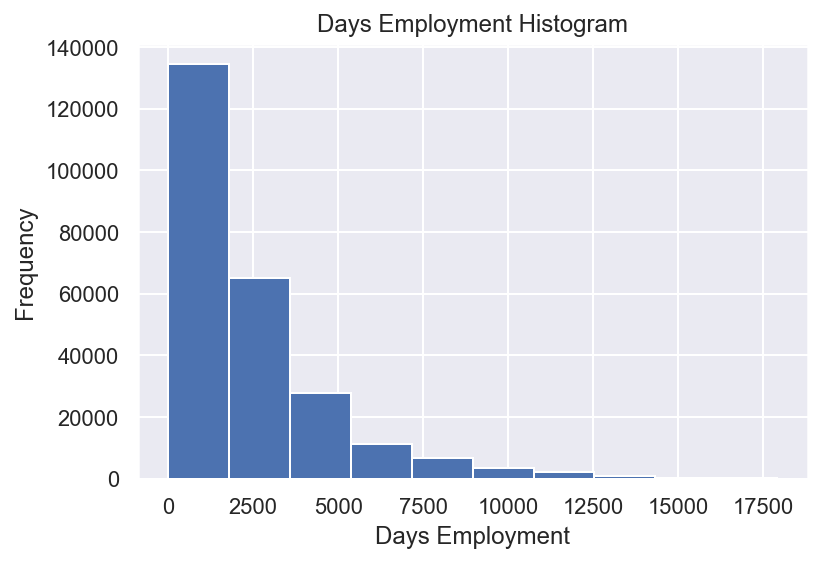

In [20]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].apply(lambda x: abs(x))

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

**Correlations**. Since there are too many features, we can't do heatmap (or at least at some degree of comprehension).

In [66]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_EMPLOYED                          -0.074958
NAME_EDUCATION_TYPE_Higher education   -0.056593
                                          ...   
NAME_INCOME_TYPE_Working                0.057481
REGION_RATING_CLIENT                    0.058899
REGION_RATING_CLIENT_W_CITY             0.060893
DAYS_BIRTH                              0.078239
TARGET                                  1.000000
Name: TARGET, Length: 247, dtype: float64

In [67]:
pd.DataFrame(correlations)

,TARGET
EXT_SOURCE_3,-0.178919
EXT_SOURCE_2,-0.160472
EXT_SOURCE_1,-0.155317
DAYS_EMPLOYED,-0.074958
NAME_EDUCATION_TYPE_Higher education,-0.056593
...,...
NAME_INCOME_TYPE_Working,0.057481
REGION_RATING_CLIENT,0.058899
REGION_RATING_CLIENT_W_CITY,0.060893
DAYS_BIRTH,0.078239


In [22]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Since DAYS_BIRTH has the most positive corr, which is a bit confusing. Let's calculate the age of the clients.

In [23]:
app_train.DAYS_BIRTH.describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

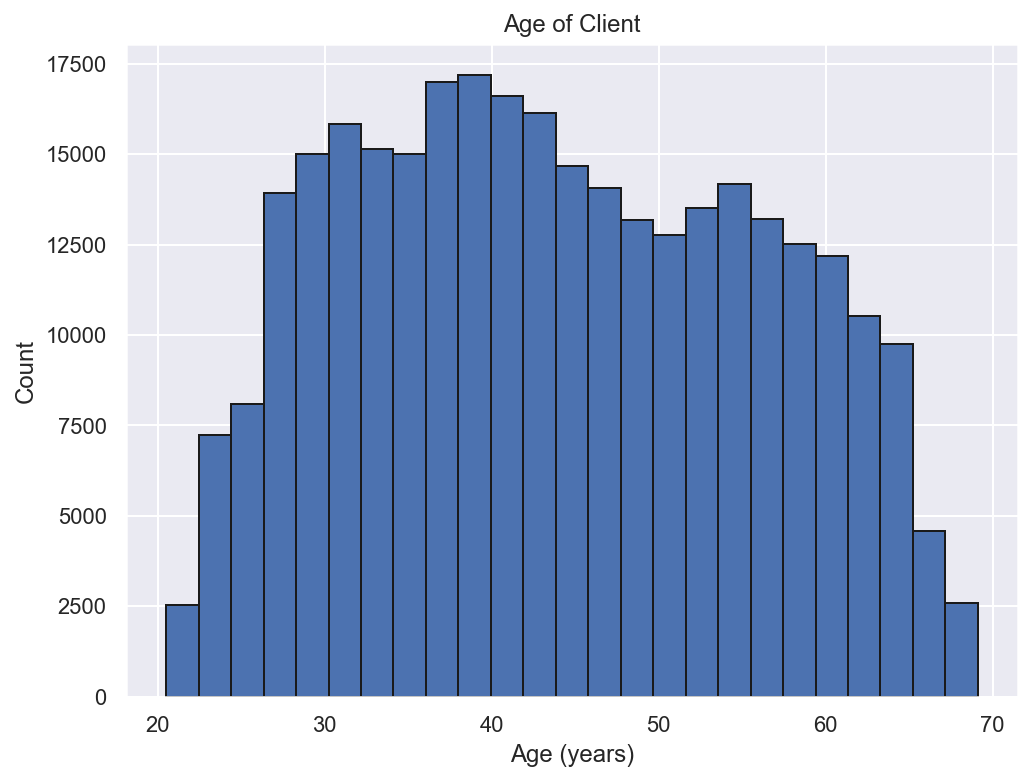

In [63]:
# Plot the distribution of ages in years
plt.figure(figsize = (8, 6))
plt.hist(app_train['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.savefig('age_dist.png')

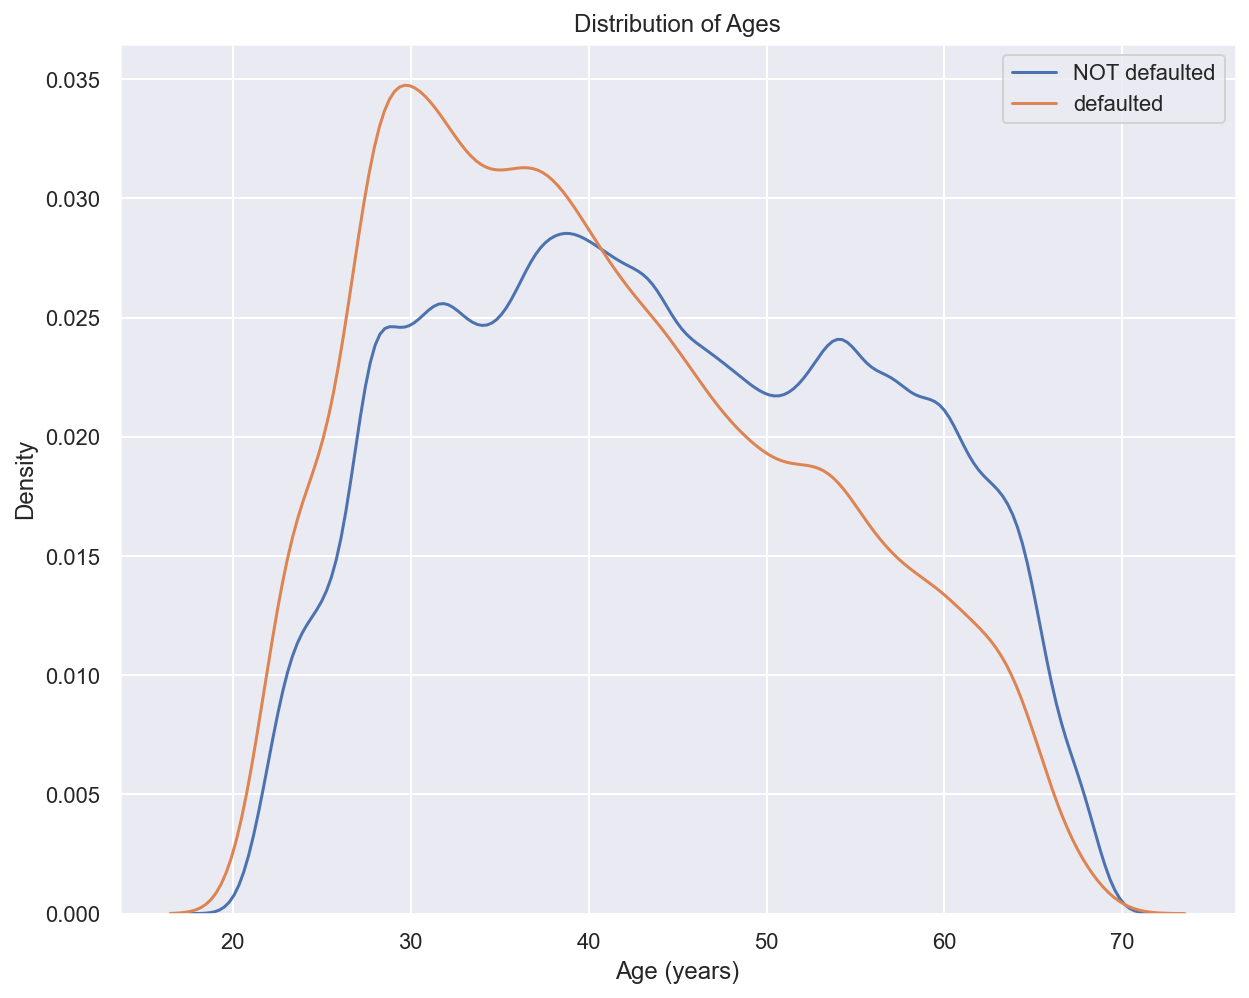

In [25]:
plt.figure(figsize = (10,8))

#KDE plot of loans that were not defaulted
sns.kdeplot(app_train.loc[app_train.TARGET == 0, 'DAYS_BIRTH'] / -365, label = 'NOT defaulted')

#KDE plot of loans there were defaulted
sns.kdeplot(app_train.loc[app_train.TARGET == 1, 'DAYS_BIRTH'] / -365, label = 'defaulted')

# Labeling of plot
plt.xlabel('Age (years)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Ages');
plt.legend();

Intuitively, age effects how the application turns out.

In [26]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365
age_data['DAYS_BIRTH'] = abs(age_data['DAYS_BIRTH'])

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [27]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


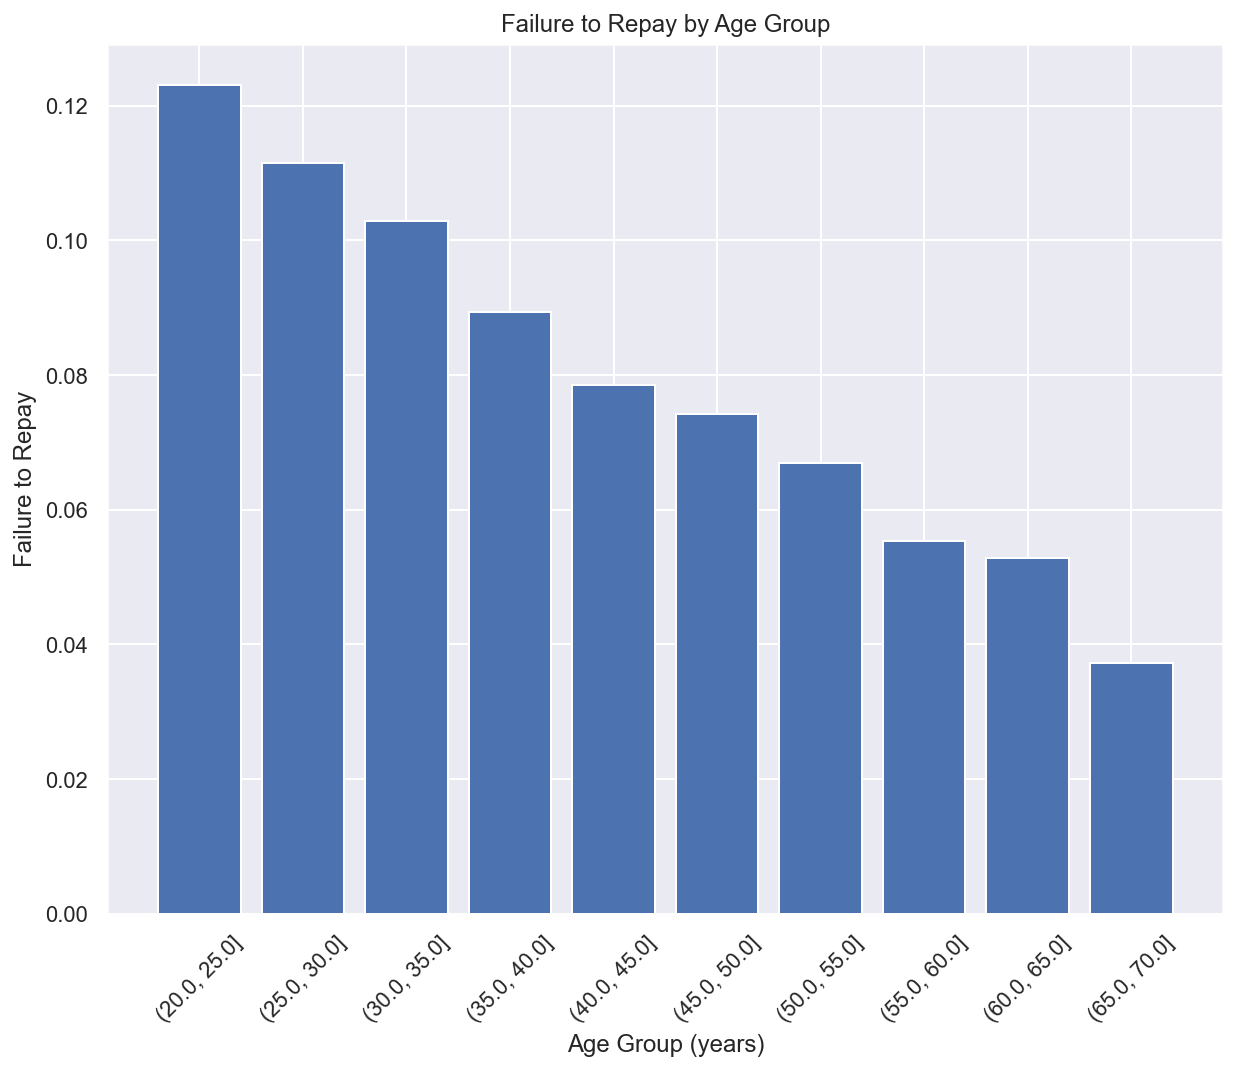

In [62]:
plt.figure(figsize = (10, 8))

plt.bar(age_groups.index.astype(str), age_groups.TARGET)

plt.xticks(rotation = 45)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay')
plt.title('Failure to Repay by Age Group');
plt.savefig('age_grouped_vs_target.png')

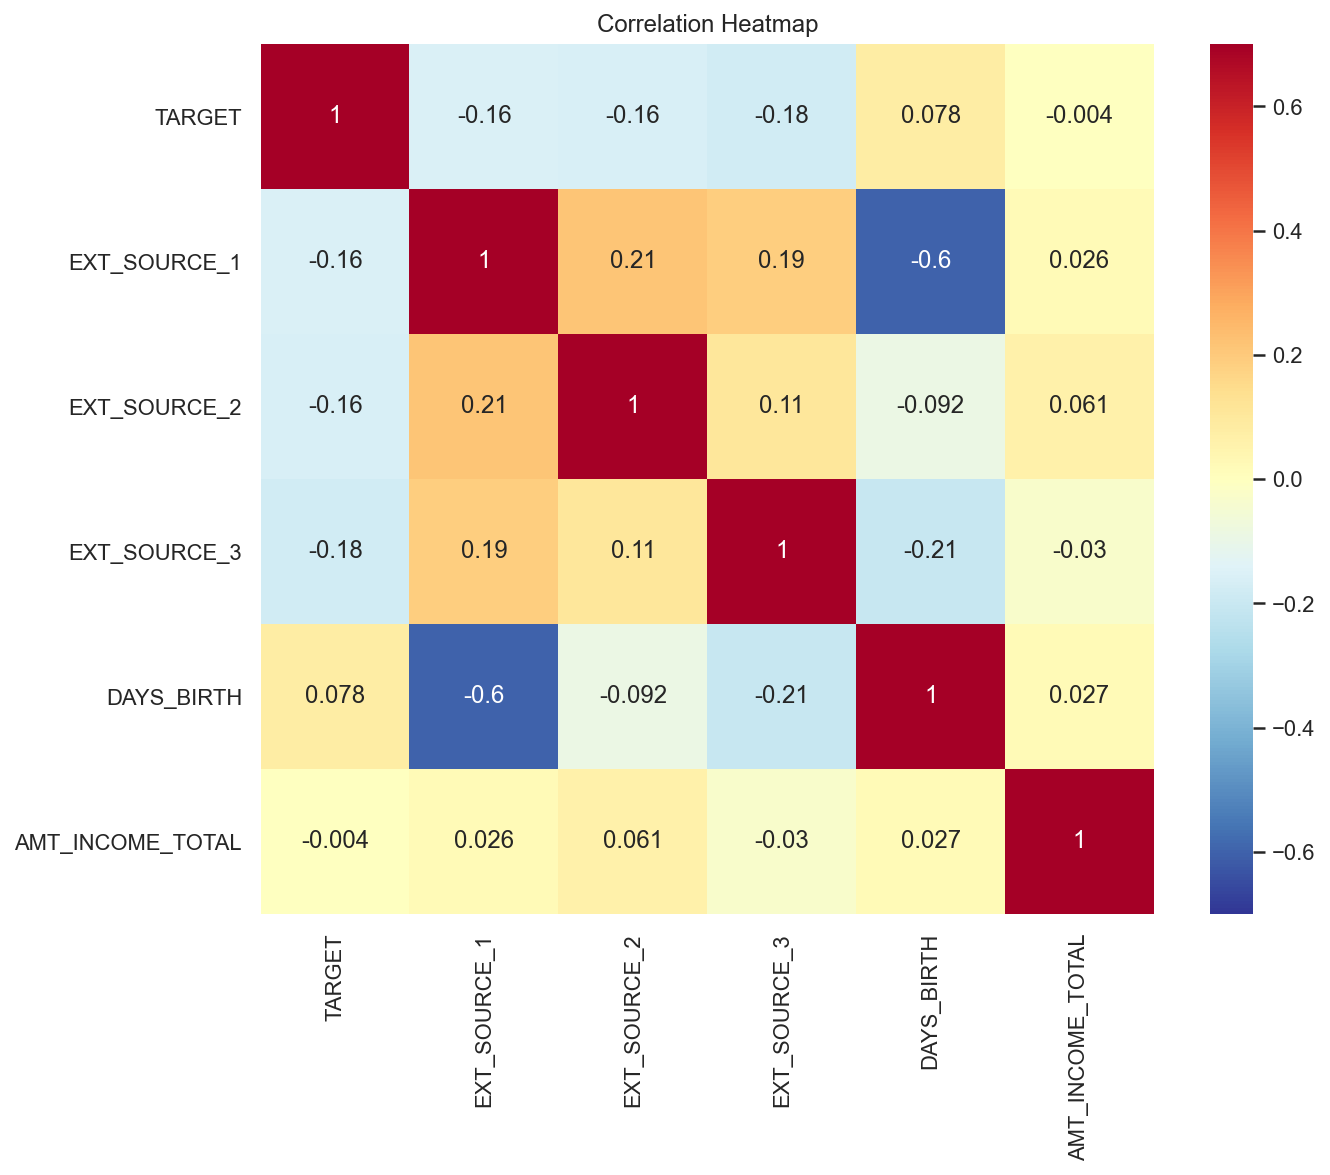

In [70]:
plt.figure(figsize = (10, 8))

# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']]
ext_data_corrs = ext_data.corr()

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.7, annot = True, vmax = 0.7)
plt.title('Correlation Heatmap');

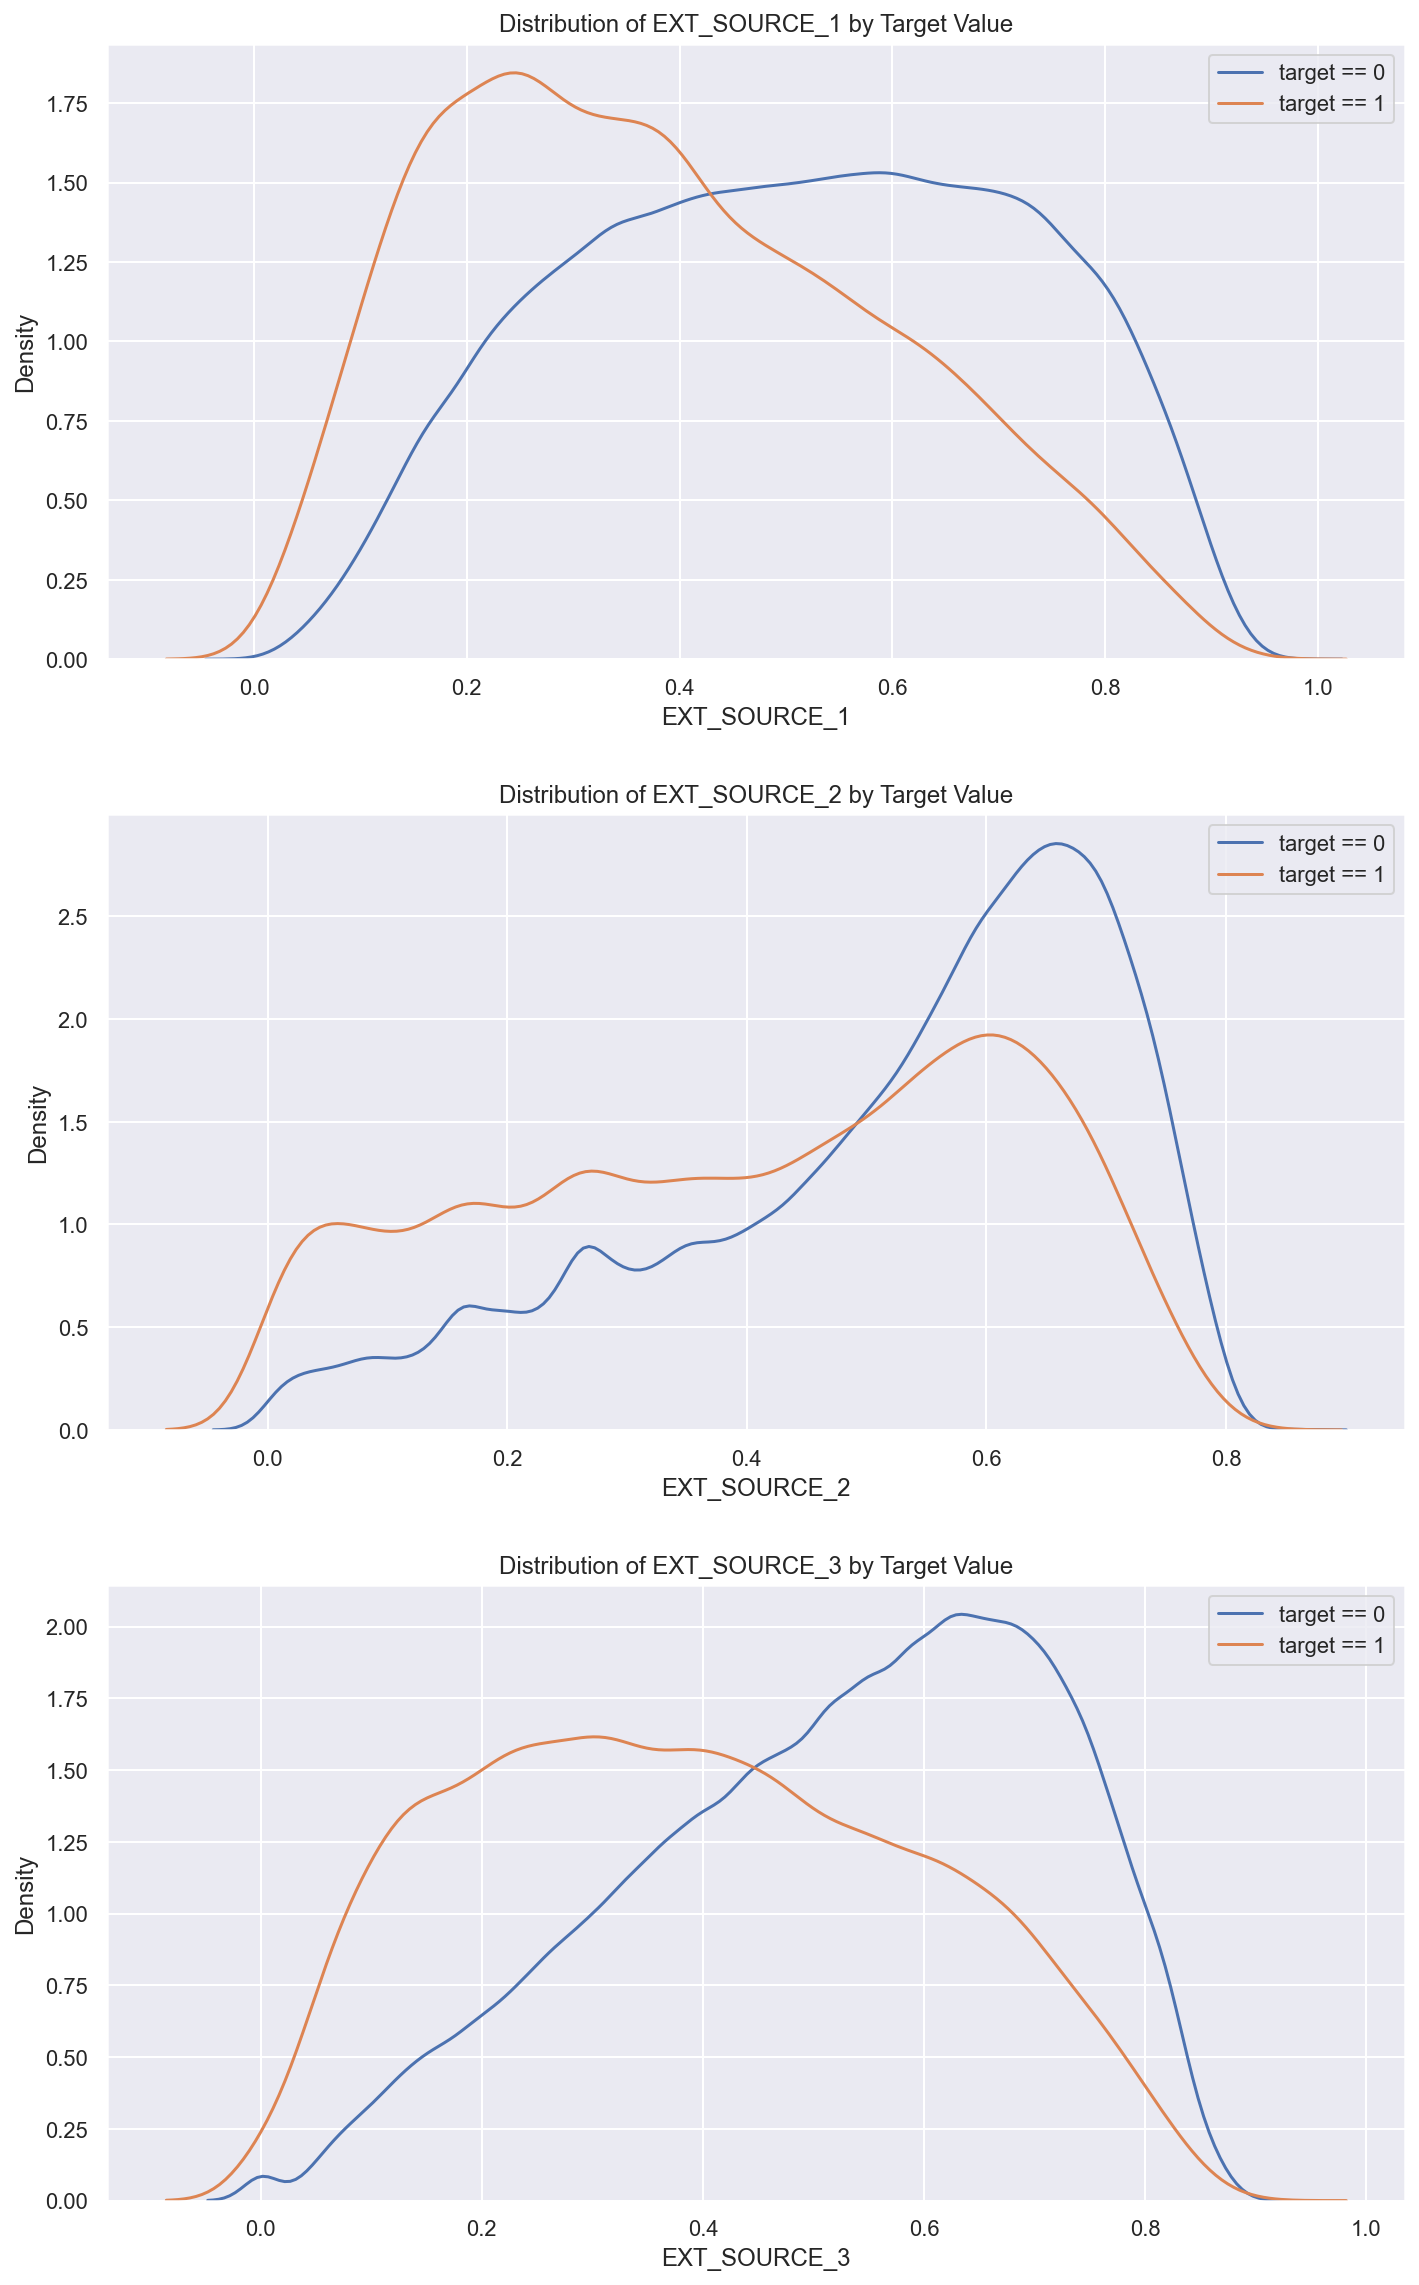

In [71]:
plt.figure(figsize = (10, 16))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)
#plt.savefig('ext_source_vs_target.png')

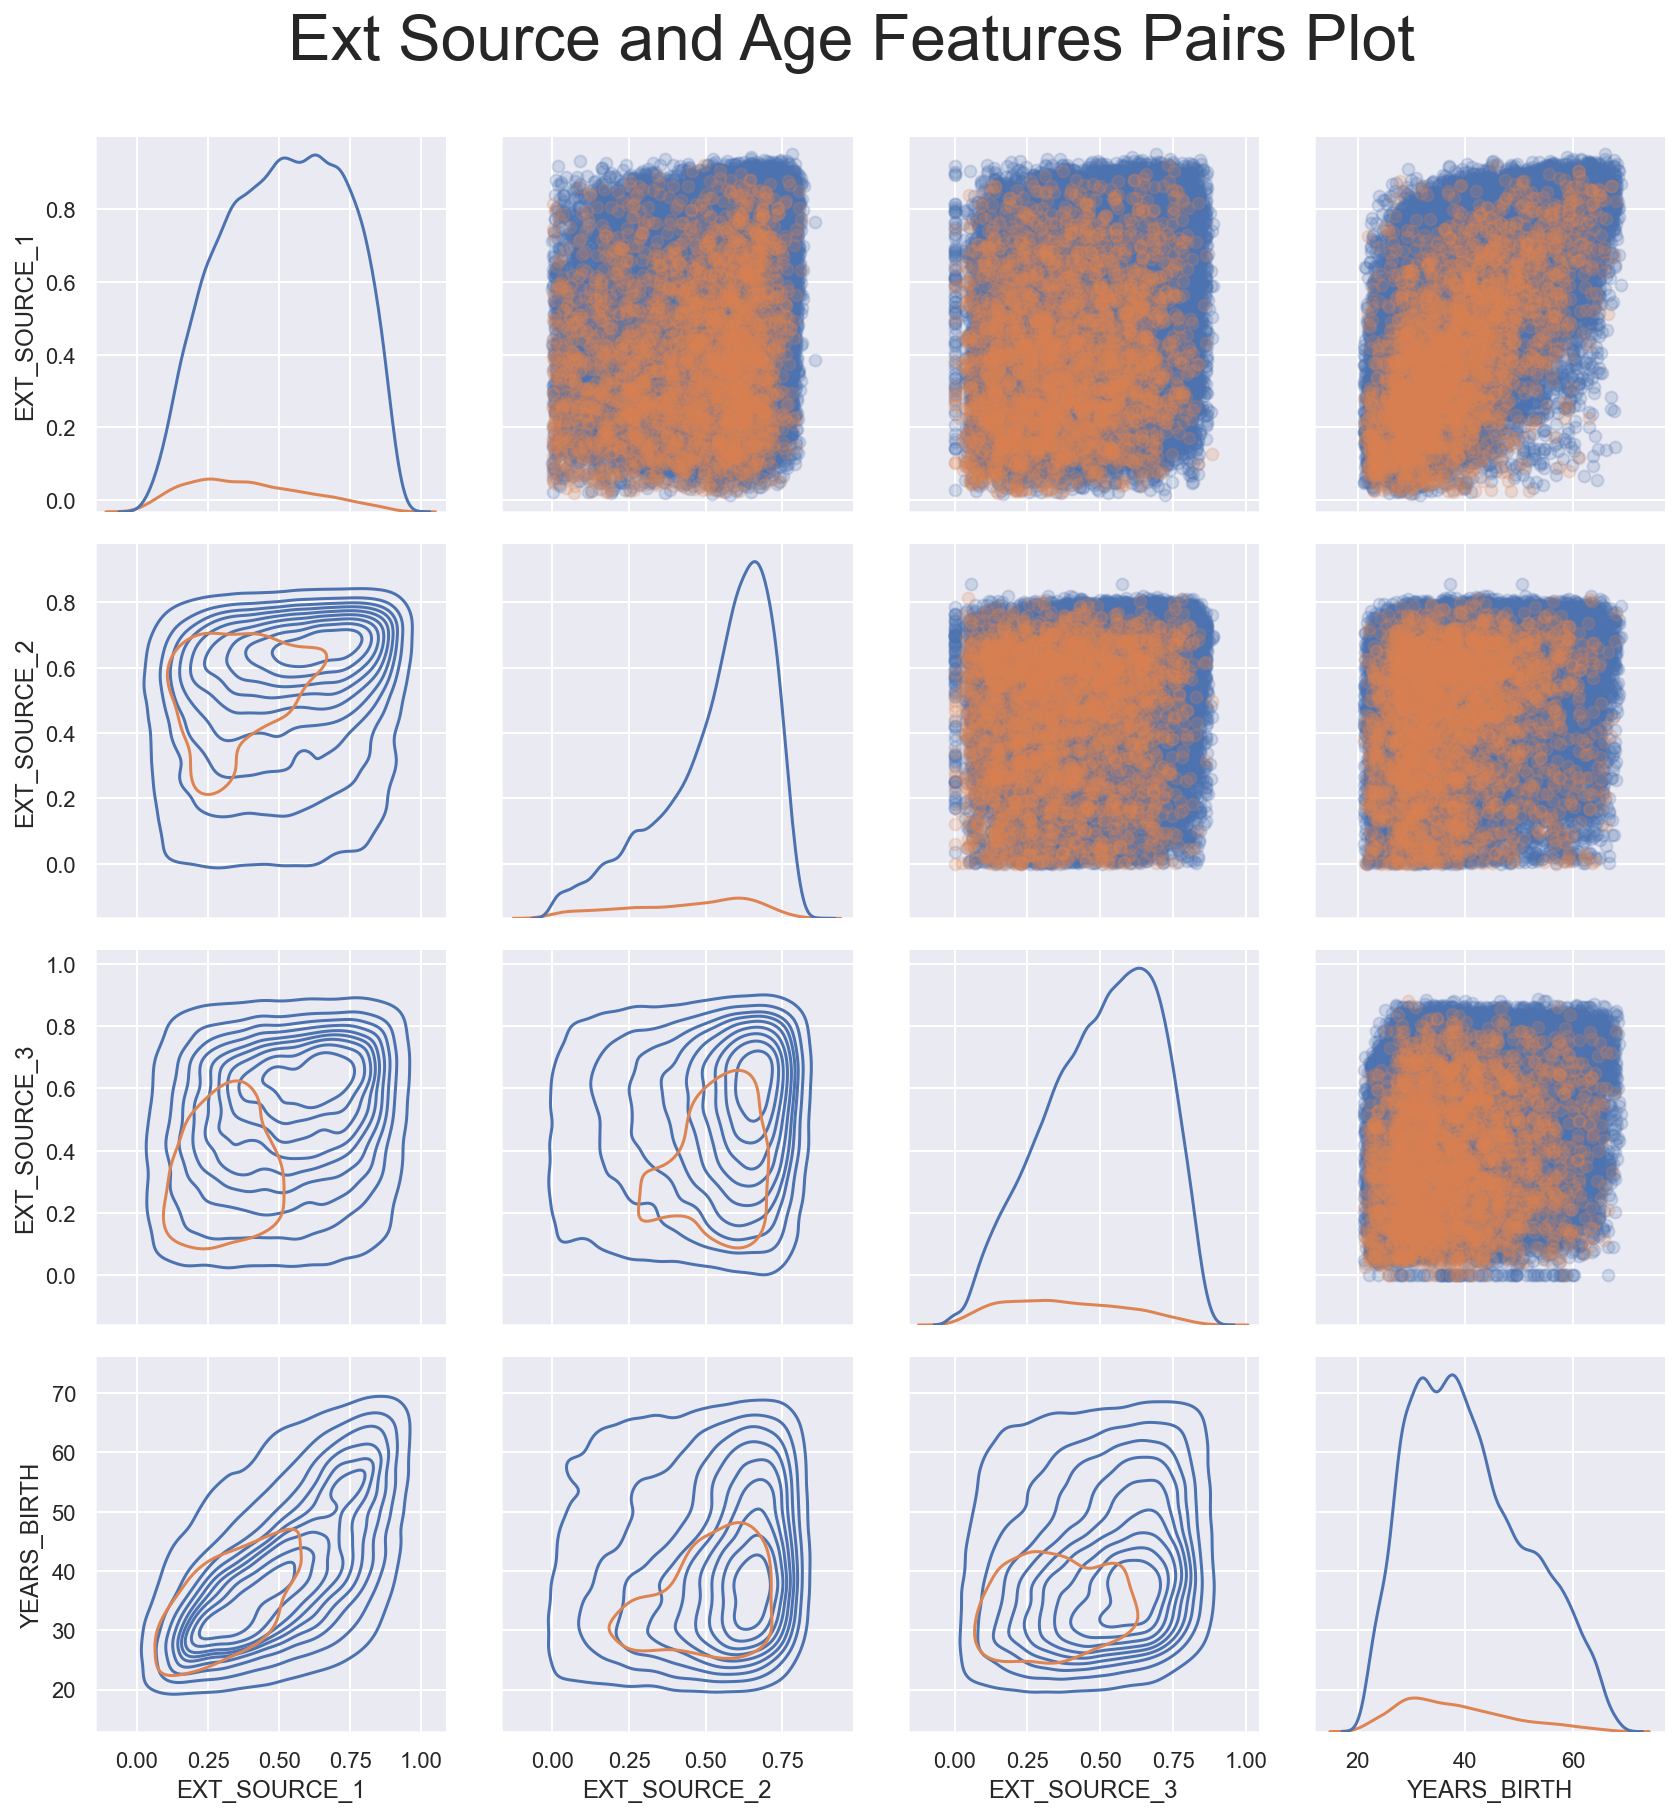

In [31]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In [32]:
app_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,637.0,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,1188.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,225.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,3039.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,3038.0,...,0,0,0,0,0,0,0,0,0,False


### Feature Engineering

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

In [34]:
X_train, X_test, y_train, y_test = train_test_split(app_train.drop(columns=['TARGET']), 
                                                    app_train.TARGET, test_size=0.2, random_state=42)

In [35]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (246008, 246)
X_test shape:  (61503, 246)
y_train shape:  (246008,)
y_test shape:  (61503,)


In [36]:
app_train.to_csv('app_train.csv')

#### Polynomial features

In [37]:
# Make a new dataframe for polynomial features
poly_features = X_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_features_test = X_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
imputer = SimpleImputer(strategy='mean')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [38]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (246008, 35)


In [39]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [40]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = y_train

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3     -0.004388
EXT_SOURCE_2^2 EXT_SOURCE_3   -0.004284
EXT_SOURCE_2 EXT_SOURCE_3^2   -0.004011
EXT_SOURCE_2^3                -0.003426
EXT_SOURCE_2^2                -0.003352
EXT_SOURCE_3                  -0.003241
DAYS_BIRTH^3                  -0.003135
EXT_SOURCE_2                  -0.003093
EXT_SOURCE_3^2                -0.002981
DAYS_BIRTH                    -0.002777
Name: TARGET, dtype: float64
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.001909
EXT_SOURCE_1 DAYS_BIRTH^2               0.002639
DAYS_BIRTH^2                            0.003023
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


In [41]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = X_train['SK_ID_CURR']
X_train_poly = X_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = X_test['SK_ID_CURR']
X_test_poly = X_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
X_train_poly, X_test_poly = X_train_poly.align(X_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', X_train_poly.shape)
print('Testing data with polynomial features shape:  ', X_test_poly.shape)

Training data with polynomial features shape:  (246008, 281)
Testing data with polynomial features shape:   (61503, 281)


#### Domain knowlegde features

`CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income <br/>
`ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income <br/>
`CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due <br/>
`DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [42]:
X_train_domain = X_train.copy()
X_test_domain = X_test.copy()

X_train_domain['CREDIT_INCOME_PERCENT'] = X_train_domain['AMT_CREDIT'] / X_train_domain['AMT_INCOME_TOTAL']
X_train_domain['ANNUITY_INCOME_PERCENT'] = X_train_domain['AMT_ANNUITY'] / X_train_domain['AMT_INCOME_TOTAL']
X_train_domain['CREDIT_TERM'] = X_train_domain['AMT_ANNUITY'] / X_train_domain['AMT_CREDIT']
X_train_domain['DAYS_EMPLOYED_PERCENT'] = X_train_domain['DAYS_EMPLOYED'] / X_train_domain['DAYS_BIRTH']

X_test_domain['CREDIT_INCOME_PERCENT'] = X_test_domain['AMT_CREDIT'] / X_test_domain['AMT_INCOME_TOTAL']
X_test_domain['ANNUITY_INCOME_PERCENT'] = X_test_domain['AMT_ANNUITY'] / X_test_domain['AMT_INCOME_TOTAL']
X_test_domain['CREDIT_TERM'] = X_test_domain['AMT_ANNUITY'] / X_test_domain['AMT_CREDIT']
X_test_domain['DAYS_EMPLOYED_PERCENT'] = X_test_domain['DAYS_EMPLOYED'] / X_test_domain['DAYS_BIRTH']

In [43]:
X_train_domain.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
123473,243191,0,171000.0,555273.0,16366.5,463500.0,0.035792,-23349,NaN,-3595.0,...,0,0,0,0,0,True,3.247211,0.095711,0.029475,NaN
10118,111778,1,157500.0,198085.5,23638.5,171000.0,0.010032,-10921,117.0,-4281.0,...,0,1,0,1,0,False,1.257686,0.150086,0.119335,-0.010713
64716,175057,0,135000.0,776304.0,25173.0,648000.0,0.035792,-23213,2157.0,-5680.0,...,0,0,0,0,0,False,5.750400,0.186467,0.032427,-0.092922
234940,372147,1,164133.0,900000.0,36787.5,900000.0,0.030755,-10703,2530.0,-2618.0,...,1,0,0,1,0,False,5.483358,0.224132,0.040875,-0.236382
236051,373412,0,225000.0,533668.5,21294.0,477000.0,0.025164,-15798,3520.0,-8006.0,...,0,0,0,0,0,False,2.371860,0.094640,0.039901,-0.222813


In [44]:
X_train_domain

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
123473,243191,0,171000.0,555273.0,16366.5,463500.0,0.035792,-23349,NaN,-3595.0,...,0,0,0,0,0,True,3.247211,0.095711,0.029475,NaN
10118,111778,1,157500.0,198085.5,23638.5,171000.0,0.010032,-10921,117.0,-4281.0,...,0,1,0,1,0,False,1.257686,0.150086,0.119335,-0.010713
64716,175057,0,135000.0,776304.0,25173.0,648000.0,0.035792,-23213,2157.0,-5680.0,...,0,0,0,0,0,False,5.750400,0.186467,0.032427,-0.092922
234940,372147,1,164133.0,900000.0,36787.5,900000.0,0.030755,-10703,2530.0,-2618.0,...,1,0,0,1,0,False,5.483358,0.224132,0.040875,-0.236382
236051,373412,0,225000.0,533668.5,21294.0,477000.0,0.025164,-15798,3520.0,-8006.0,...,0,0,0,0,0,False,2.371860,0.094640,0.039901,-0.222813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,239009,0,121500.0,675000.0,32602.5,675000.0,0.006305,-14481,1124.0,-3813.0,...,0,0,0,0,0,False,5.555556,0.268333,0.048300,-0.077619
259178,399937,2,225000.0,509922.0,40419.0,472500.0,0.003069,-15492,292.0,-1613.0,...,0,0,0,0,0,False,2.266320,0.179640,0.079265,-0.018848
131932,253016,0,450000.0,1125000.0,33025.5,1125000.0,0.014520,-14309,5929.0,-5038.0,...,1,0,0,1,0,False,2.500000,0.073390,0.029356,-0.414355
146867,270275,1,180000.0,270000.0,13500.0,270000.0,0.010006,-12706,1868.0,-923.0,...,0,1,0,1,0,False,1.500000,0.075000,0.050000,-0.147017


In [45]:
X_test_domain

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
245895,384575,2,207000.0,465457.5,52641.0,418500.0,0.009630,-13297,762.0,-637.0,...,0,0,0,0,0,False,2.248587,0.254304,0.113095,-0.057306
98194,214010,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,-14778,1141.0,-1610.0,...,0,0,0,1,0,False,5.178636,0.197764,0.038188,-0.077209
36463,142232,0,202500.0,495000.0,39109.5,495000.0,0.035792,-17907,639.0,-2507.0,...,0,0,0,0,0,False,2.444444,0.193133,0.079009,-0.035684
249923,389171,0,247500.0,254700.0,24939.0,225000.0,0.046220,-19626,6982.0,-11167.0,...,1,0,0,1,0,False,1.029091,0.100764,0.097915,-0.355753
158389,283617,0,112500.0,308133.0,15862.5,234000.0,0.018850,-20327,1105.0,-7299.0,...,0,1,0,1,0,False,2.738960,0.141000,0.051479,-0.054361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256564,396891,2,450000.0,900000.0,45000.0,900000.0,0.003541,-18622,2097.0,-5335.0,...,0,0,1,0,1,False,2.000000,0.100000,0.050000,-0.112609
278889,423085,0,225000.0,202500.0,24030.0,202500.0,0.028663,-12325,187.0,-1196.0,...,0,0,0,0,0,False,0.900000,0.106800,0.118667,-0.015172
221828,356971,0,121500.0,254700.0,30357.0,225000.0,0.003818,-23629,NaN,-2376.0,...,0,0,0,1,0,True,2.096296,0.249852,0.119187,NaN
190245,320581,1,112500.0,1314117.0,38551.5,1147500.0,0.007120,-17350,4118.0,-2618.0,...,0,0,0,0,0,False,11.681040,0.342680,0.029336,-0.237349


In [46]:
X_train_domain.to_csv('X_train_domain.csv')
X_test_domain.to_csv('X_test_domain.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

### Baseline Models

#### Logistic Regression

In [47]:
X_train_lr = X_train_domain.copy()
X_test_lr = X_test_domain.copy()

In [48]:
#features columns
features = list(X_train_domain.columns)

#test set

#SimpleImputer wirth strategy = median
imputer = SimpleImputer(strategy='median')

#Scale the features
scaler = StandardScaler()


In [49]:
#Fit on the training data

#Imputer
imputer.fit(X_train_lr)
X_train_lr = imputer.transform(X_train_lr)
X_test_lr = imputer.transform(X_test_lr)

#Scaler
scaler.fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

print('X_train shape: ', X_train_lr.shape)
print('X_test shape: ', X_test_lr.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)


In [50]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.001)

# Train on the training data
log_reg.fit(X_train_lr, y_train)

# Make predictions
log_reg_pred = log_reg.predict(X_test_lr)

In [51]:
print("ROC AUC score on train set: ", roc_auc_score(y_train, log_reg.predict_proba(X_train_lr)[:, 1]))
print("ROC AUC score on test set: ", roc_auc_score(y_test, log_reg.predict_proba(X_test_lr)[:, 1]))
print("F1 score on train set: ", f1_score(y_true=y_train, y_pred=log_reg.predict(X_train_lr)))
print("F1 score on test set: ", f1_score(y_true=y_test, y_pred=log_reg.predict(X_test_lr)))
print("Precision score on train set: ", precision_score(y_true=y_train, y_pred=log_reg.predict(X_train_lr)))
print("Precision score on test set: ", precision_score(y_true=y_test, y_pred=log_reg.predict(X_test_lr)))
print("Recall score on train set: ", recall_score(y_true=y_train, y_pred=log_reg.predict(X_train_lr)))
print("Recall score on test set: ", recall_score(y_true=y_test, y_pred=log_reg.predict(X_test_lr)))

ROC AUC score on train set:  0.7490905000812762
ROC AUC score on test set:  0.7485525468667489
F1 score on train set:  0.016535472053071935
F1 score on test set:  0.01900237529691211
Precision score on train set:  0.5170278637770898
Precision score on test set:  0.46601941747572817
Recall score on train set:  0.008402092976454015
Recall score on test set:  0.009698929076581127


In [52]:
from sklearn.model_selection import cross_val_predict, cross_val_score

In [53]:
log_reg

LogisticRegression(C=0.001)

In [54]:
y_scores = cross_val_predict(log_reg, X_train_lr, y_train, cv=3,
                             method="decision_function")
print(y_scores)

[-3.02344072 -1.97033858 -2.99943153 ... -3.6018395  -2.6956405
 -1.8075558 ]


In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

recall_50_precision = recalls[np.argmax(precisions >= 0.50)]

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

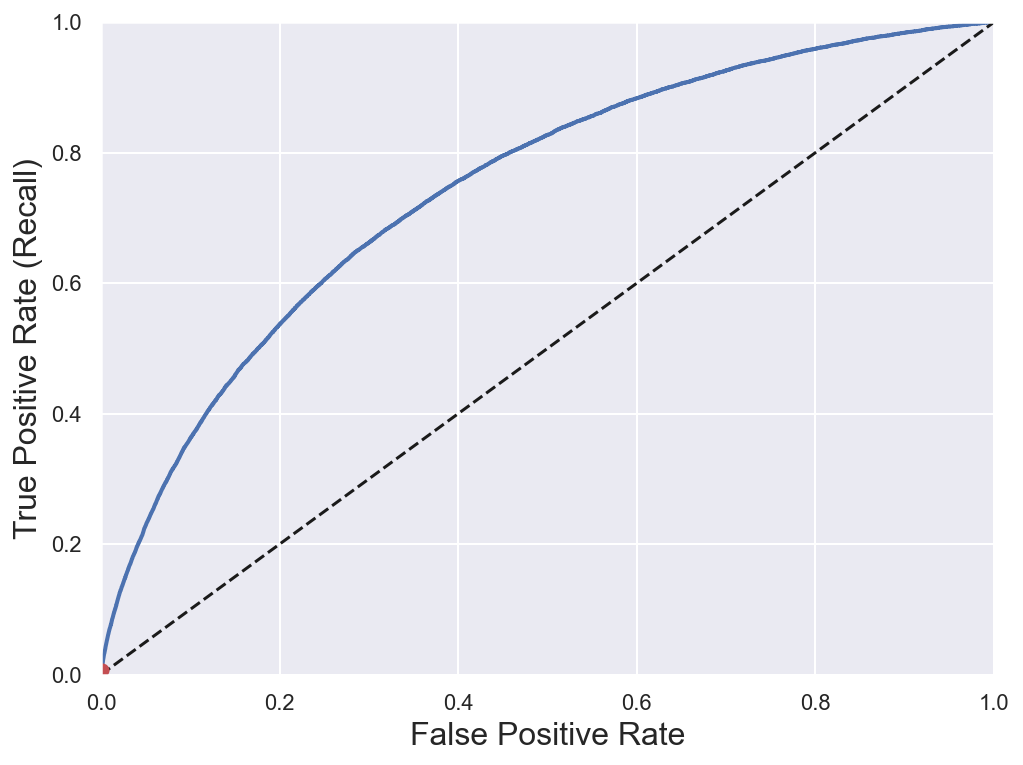

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_50 = fpr[np.argmax(tpr >= recall_50_precision)]           
plt.plot([fpr_50, fpr_50], [0., recall_50_precision], "r:")   
plt.plot([0.0, fpr_50], [recall_50_precision, recall_50_precision], "r:") 
plt.plot([fpr_50], [recall_50_precision], "ro")      
plt.show()

In [58]:
type(y_train)

pandas.core.series.Series

In [59]:
X_train_domain.shape

(246008, 250)